<a href="https://colab.research.google.com/github/deepu-san/Projects/blob/main/Predict%20The%20News%20Category/Predict_The_News_Category.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB



In [4]:
path="https://github.com/deepu-san/Projects/blob/main/Predict%20The%20News%20Category/Data_Train.xlsx?raw=true"
df = pd.read_excel(path)
df.head(3)

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3.0
1,How formidable is the opposition alliance amon...,0.0
2,Most Asian currencies were trading lower today...,3.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7628 entries, 0 to 7627
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STORY    7628 non-null   object 
 1   SECTION  7628 non-null   float64
dtypes: float64(1), object(1)
memory usage: 119.3+ KB


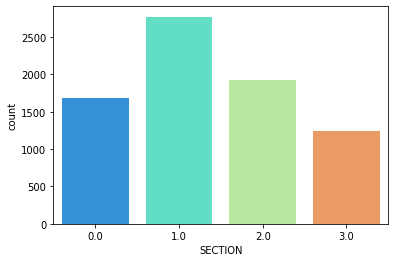

In [6]:
sns.countplot(x='SECTION',data=df,palette='rainbow')


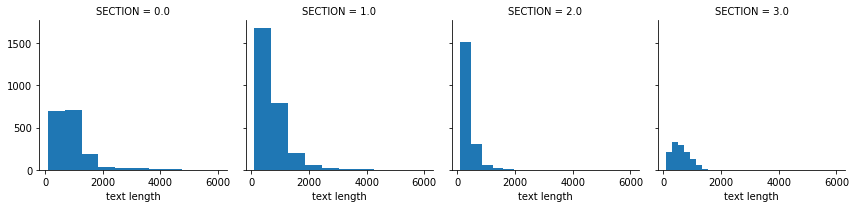

In [7]:
df['text length'] = df['STORY'].apply(len)
g = sns.FacetGrid(df,col='SECTION')
g.map(plt.hist,'text length')

# TF-IDF

In [32]:
df['story_processed'] = df['STORY'].str.replace("[^a-zA-Z0-9]", " ")
df['story_processed'] = df['story_processed'].apply(lambda row: ' '.join([word for word in row.split() if len(word)>2]))
df['story_processed'] = [review.lower() for review in df['story_processed']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [33]:
# Removing Stopwords Begin
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
stop_words = stopwords.words('english')

# Function to remove stop words 
def remove_stopwords(rev):
    # iNPUT : IT WILL TAKE ROW/REVIEW AS AN INPUT
    # take the paragraph, break into words, check if the word is a stop word, remove if stop word, combine the words into a para again
    review_tokenized = word_tokenize(rev)
    rev_new = " ".join([i for i in review_tokenized  if i not in stop_words])
    return rev_new

# Removing stopwords
df['story_processed'] = [remove_stopwords(r) for r in df['story_processed']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [34]:
# Begin Lemmatization 
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger') # Run atleast once 

# function to convert nltk tag to wordnet tag
lemmatizer = WordNetLemmatizer()
nltk.download('omw-1.4')

# Finds the part of speech tag
# Convert the detailed POS tag into a shallow information
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# lemmatize sentence using pos tag
def lemmatize_sentence(sentence):
  # word tokenize -> pos tag (detailed) -> wordnet tag (shallow pos) -> lemmatizer -> root word
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


df['story_processed'] = df['story_processed'].apply(lambda x: lemmatize_sentence(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [35]:
tfidf = TfidfVectorizer(max_features=2500)
X = tfidf.fit_transform(df.story_processed).toarray()
y = df.SECTION.values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)


In [37]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)

In [38]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("The model accuracy is", accuracy )

[[293  17  21   6]
 [ 12 481  29  29]
 [ 13  11 343   9]
 [ 11  37   8 206]]
The model accuracy is 0.8669724770642202


In [39]:
roc_auc_score(y_test, dt.predict_proba(X_test),multi_class='ovr')

0.909764390954517

# Multinomial Naive Bayesian

In [8]:
X = df['STORY']
y = df['SECTION']

In [24]:
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB()

In [25]:
predictions = nb.predict(X_test)

In [27]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[338   7  12   2]
 [  8 528   6  10]
 [  8   8 351   1]
 [  2   4   0 241]]


              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       359
         1.0       0.97      0.96      0.96       552
         2.0       0.95      0.95      0.95       368
         3.0       0.95      0.98      0.96       247

    accuracy                           0.96      1526
   macro avg       0.95      0.96      0.96      1526
weighted avg       0.96      0.96      0.96      1526



In [31]:
roc_auc_score(y_test, nb.predict_proba(X_test),multi_class='ovr')

0.996308058250551